# Simulating Anenke

In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [4]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('data/naif0009.tls.txt')
    if k == '310+341+435':
            spice.furnsh('data/jup310.bsp')
            spice.furnsh('data/jup341.bsp')
            spice.furnsh('data/de435.bsp')
    elif k == '310+341':
            spice.furnsh('data/jup310.bsp')
            spice.furnsh('data/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('data/de435.bsp')
            spice.furnsh('data/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('data/jup341.bsp')
            spice.furnsh('data/de435.bsp')
    elif k == '310':
            spice.furnsh('data/jup310.bsp')
    elif k == '341':
            spice.furnsh('data/jup341.bsp')
    elif k == '435':
            spice.furnsh('data/de435.bsp')
    pass

In [5]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

In [45]:
def SimStart2(bsolar,msolar,iJovian,Ms,J2):
    '''
    Starts the simulation. Adds all particles
    
    Arguments:
    
    bsolar: list of strs
    
    The names of the bodies added. Typically: '1','2','3','4', 'Jupiter','Io','Ananke'. 'Jupiter' must be added
    last followed by the satellites in the system
    
    msolar: list of floats
    
    The masses of the bodies in bsolar. Must be at the order of bsolar
    
    iJovian: list, int
    
    The indexes (+1) that the satellites in the solar system have in bsolar
    
    '''
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = np.sqrt(Ms*10**9)*(1.49597870700*10**11)**(-1.5) *86400.00000
    sim.G = k**2
    sim.add(m=1.)
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t)
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2],hash=bsolar[i])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            ps[j].calculate_orbit(primary=ps[0])
        elif bsolar[j-1] == 'Moon':
            ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1])
        else:
            if 'Jupiter' in bsolar:
                ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1])
            else:
                ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1])
    sim.move_to_com()
    jupcom = sim.calculate_com(first=8)
    print(jupcom-sim.particles[3])
    if J2 > 0:
        import reboundx
        rebx = reboundx.Extras(sim)
        j2 = rebx.load_force('gravitational_harmonics')
        rebx.add_force(j2)
        try:
            sim.particles['Jupiter'].params['J2'] = J2
            sim.particles['Jupiter'].params['R_eq'] = 71492 / 1.496e8 # convert to AU units for sim
        except:
            sim.particles['5'].params['J2'] = J2
            sim.particles['5'].params['R_eq'] = 71492 / 1.496e8 # convert to AU
    return ps,sim

In [42]:
def Integrator(bsolar,msolar,iJovian,body1,body2,Ms,J2):
    '''
    Integrates the system. If body1 or body2 refer to the Jupiter Barycenter, while there are bodies in the Jovian system
    teh function will compute the barycenter in the simulation
    
    Arguments:
    
    bsolar
    msolar
    iJovian
    
    body1 and body2: name in str
    
    The spice names of the bodies that we want to look into to check the error of our integrator
    
     '''
    ps,sim = SimStart2(bsolar,msolar,iJovian,Ms,J2)
    xm = []
    ym = []
    zm = []
    xan = []
    yan = []
    distance = []
    Nout = 1000
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        if body2 == '5' and len(iJovian)>1 :
                jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
                xan.append(ps[bsolar.index(body1)+1].x - jupcom.x)
                yan.append(ps[bsolar.index(body1)+1].y - jupcom.y)
        elif body1 == '5' and len(iJovian)>1:
                jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
                xan.append(jupcom.x - ps[0].x)
                yan.append(jupcom.y - ps[0].y)
        else:    
                xan.append(0)
                yan.append(0)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,xm,ym,times,distance,xan,yan

In [43]:
def ErrorSource(bsolar,mass,iJovian,body1,body2,Ms, J2=0):
    '''
    Returns the error of the chosen bodies as well as the entire system
    
    '''
    x,y,xm,ym,times,distance,xan,yan = Integrator(bsolar,mass,iJovian,body1,body2,Ms, J2)
    if (body2 == '5' or body1 == '5') and len(iJovian)>1:
        dist1 = np.array(xan)
        dist2 = np.array(yan)
    elif body2 == 'Sun':
        temp = 0
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
    else:
        temp = bsolar.index(body2)+1
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
    print(len(dist1),len(xm),len(x[0]))
    return np.array(dist1-xm),np.array(dist2-ym),times,distance,x,y

Gravitational parameters of all bodies that may be needed. The 432 spice kernel file (same with 435 just has documentation) has the masses of the barycenters of the solar system, as well as the Earth and Moon separately. The 310 file has all the barycenters in the solar system as if the terrestrial planets were one with the Sun as well as the Jovian satellites.
We also use the 341 file for Ananke (and other irregulars in the Jovian system)

In [30]:
# From 432 (km^3/s^2)
GMEarth = 398600.435420
GMMoon = 27068703.151194

GMMercuryB = 22031.780000
GMVenusB = 324858.592000
GMEarthB = 403503.235502
GMMarsB = 42828.375214
GMJupiterB = 126712764.133446
GMSaturnB = 37940585.200000
GMUranusB = 5794556.465752
GMNeptuneB = 6836527.100580
GMSun = 132712440041.939400 # Just Sun
GMSunterr = GMSun + GMMercuryB + GMVenusB + GMEarthB + GMMarsB

# From 310

GMJupiter = 1.266865341960128E+08
GMIo = 5.959924010272514E+03
GMEuropa = 3.202739815114734E+03
GMGanymede = 9.887819980080976E+03
GMCallisto = 7.179304867611079E+03
GMAmalthea = 1.487604677404272E-01
GM10310 = 1.327132332639000E+11

GMSaturnB310 = 3.794058500000000E+07
GMUranusB310 = 5.794548600000000E+06
GMNeptuneB310 = 6.836527100580000E+06
GMJupiterB310 = 1.267127641334463E+08

The masses of all the bodies used at some point in the integration

In [31]:
MMercuryB = GMMercuryB/GMSun
MVenusB = GMVenusB/GMSun
MEarthB = GMEarthB/GMSun
MEarth = GMEarth/GMSun
MMoon = GMMoon/GMSun
MMarsB = GMMarsB/GMSun
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
MSaturnB = GMSaturnB/GMSun
MUranusB = GMUranusB/GMSun
MNeptuneB = GMNeptuneB/GMSun
MIo = GMIo/GMSun
MEuropa = GMEuropa/GMSun
MGanymede = GMGanymede/GMSun
MCallisto = GMCallisto/GMSun
MAmalthea = GMAmalthea/GMSun

The masses of all planets but the terrestrials are in the Sun (except the Earth)

In [32]:
MJupiterB310 = GMJupiterB310/(GM10310-GMEarthB)
MSaturnB310 = GMSaturnB310/(GM10310-GMEarthB)
MUranusB310 = GMUranusB310/(GM10310-GMEarthB)
MNeptuneB310 = GMNeptuneB310/(GM10310-GMEarthB)
MEarthB310 = GMEarthB/(GM10310-GMEarthB)

# Tests to determine how many bodies to use in integration

We first simulate Ananke Having all the satellites in the system. The error is within one pixel

<rebound.particle.Particle object at 0x7f918074a440, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 12.9 s, sys: 9.41 ms, total: 12.9 s
Wall time: 12.9 s


Text(0.5, 0, 't in Years')

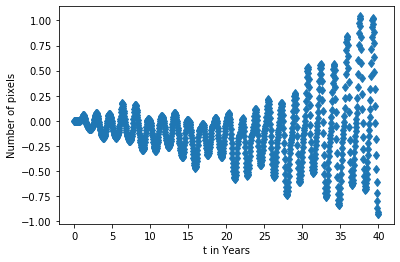

In [33]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Ananke','5',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

We then try to determine whether the error is coming from the position of the barycenter or from other factors. We look into the error of the Jupiter-Barycenter to Sun vector. The barycenter has been computed by including the satellites in the integration.

<rebound.particle.Particle object at 0x7feeb955c950, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 13.2 s, sys: 11.8 ms, total: 13.2 s
Wall time: 13.2 s


Text(0.5, 0, 't in Years')

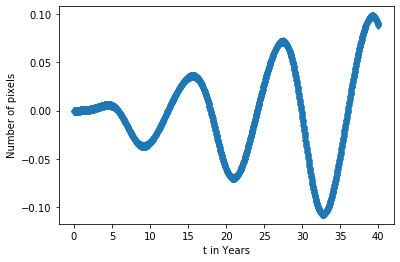

In [11]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'5','Sun',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

The Jupiter-Barycenter is not a problem as its error is at 0.1 of a pixel and does not have the periodicity of Ananke's error. We now look whether we can reduce error by removing one of the satellites from the system and adding it in Jupiter. If we can do that then our integration time will be faster. We remove Europa, which presumably perturbs Ananke and Jupiter the least.

<rebound.particle.Particle object at 0x7fee984ef560, m=0.0009517514775406744 x=-5.363981718893607 y=1.5680852438431907 z=0.8077495068621869 vx=-0.01804859214707665 vy=-0.00621288502755708 vz=-0.0026338861469840753>
1000 1000 1000
CPU times: user 11.4 s, sys: 16.8 ms, total: 11.4 s
Wall time: 11.4 s


Text(0.5, 0, 't in Years')

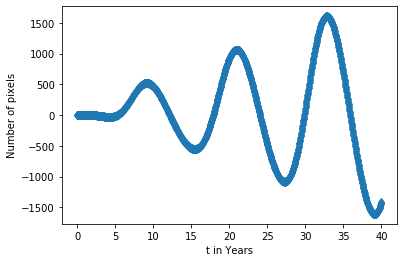

In [12]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'5','Sun',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

<rebound.particle.Particle object at 0x7feeb95f8a70, m=0.0009517307019133535 x=-5.36398160422991 y=1.5680851316636275 z=0.8077494542826176 vx=-0.018048141341180816 vy=-0.006212702566213982 vz=-0.0026337931418720967>
1000 1000 1000
CPU times: user 6.46 s, sys: 53.9 ms, total: 6.52 s
Wall time: 6.6 s


Text(0.5, 0, 't in Years')

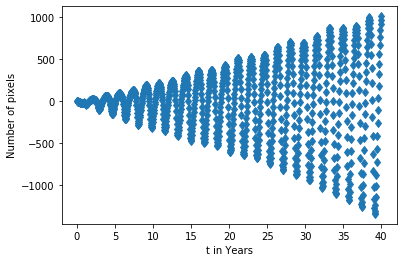

In [13]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Ananke','Jupiter',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

The error is large in both Ananke and the Barycenter. The effect is that the satellites perturb each other and consequently the barycenter of the system is severely affected when one of the satellites (even the smallest terrestrial one) is added to Jupiter. The wrongness in the barycenter affects Ananke. Now we try to look how the satellites perturb each other. First we look into Callisto's orbit with Io in the system

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 32.3 s, sys: 51.6 ms, total: 32.3 s
Wall time: 32.6 s


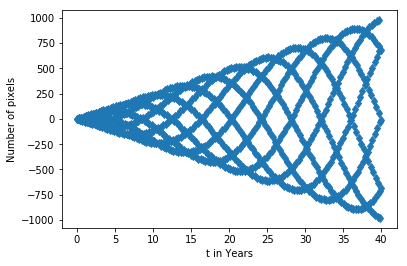

In [16]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Callisto','Sun',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

<rebound.Particle object, m=0.0009517065689849401 x=-5.363981604217797 y=1.568085131651465 z=0.8077494542769814 vx=-0.018048141330809682 vy=-0.006212702562291252 vz=-0.0026337931399284067>
1000 1000 1000
CPU times: user 14.2 s, sys: 30.7 ms, total: 14.2 s
Wall time: 14.3 s


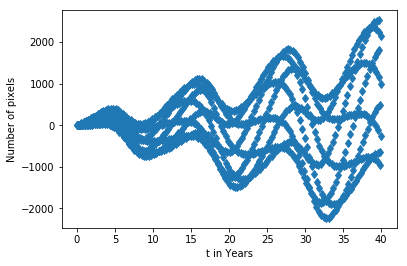

In [18]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Callisto','Sun',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

We see that removing Io from the Jovian system significantly affects the position of Callisto. This means that we cannot just remove some satellites and expect the integrator to work, as the satellites perturb each other. Removing one will change the orbit of others and the total perturbatios on Ananke will be different. Now we try to integrate with the barycenter of Jupiter, without the satellites and just Ananke which is massless and compute the result

<rebound.particle.Particle object at 0x7feeb95b6cb0, m=0.0009517514775406745 x=-5.363981605794467 y=1.5680852517748214 z=0.8077495115561961 vx=-0.01804861030546609 vy=-0.006212704363883289 vz=-0.0026338012761289616>
1000 1000 1000
CPU times: user 600 ms, sys: 5.04 ms, total: 605 ms
Wall time: 603 ms


Text(0.5, 0, 't in Years')

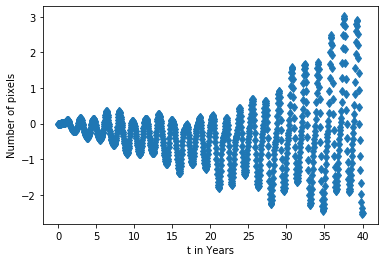

In [14]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','5','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,0],[9],'Ananke','5',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Simulating Ananke presents a trade-off between accuracy and run time. A less accurate estimate with accuracy close to 3 pixels can be provided by using only the Jupiter barycenter and thus not accounting for pertrubations from Callisto and the other satellites. This estimate will take 1.1s. A more acccurate estimate with accuracy close to 1 pixel will need 25s of integration and include the Jovian system moons.

Test to see if removing the inner terrestrial planets from the system improves runtime. Error increases by 1 pixel and runtime is improved by a factor of 3 for the short integration.

<rebound.particle.Particle object at 0x7fee985425f0, m=-5.151383772628655e-05 x=-20.759164671526502 y=19.953369548228057 z=8.683855008070381 vx=-0.0022508845654646984 vy=-0.0020432829021952773 vz=-0.0007802877845675365>
1000 1000 1000
CPU times: user 188 ms, sys: 4.62 ms, total: 193 ms
Wall time: 191 ms


Text(0.5, 0, 't in Years')

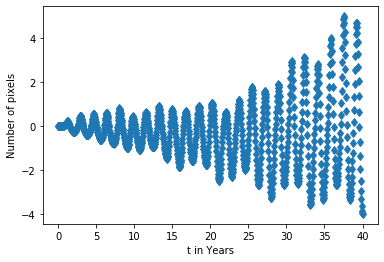

In [15]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['6','7','8','5','Ananke'],[MSaturnB,MUranusB,MNeptuneB,MJupiter,0],[5],'Ananke','5',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

If we instead add the masses of the satellites to the Sun and also change G to reflect the higher mass of the sun we get almost the same results as if we just remove the inner satellites. We lose a pixel and runtime is reduced by a factor of 3.

<rebound.particle.Particle object at 0x7f91601b3290, m=-5.1513546454149996e-05 x=-20.759164648973456 y=19.953369539675453 z=8.683855003845157 vx=-0.0022508845513371126 vy=-0.0020432828657496547 vz=-0.000780287769498422>
1000 1000 1000
CPU times: user 192 ms, sys: 4.85 ms, total: 197 ms
Wall time: 195 ms


Text(0.5, 0, 't in Years')

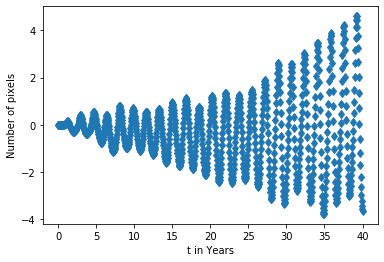

In [13]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MSaturn = (GMSaturnB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MUranus = (GMUranusB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MNeptune = (GMNeptuneB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
gmSun = (GMSun+GMMercuryB+GMVenusB+GMEarthB)

xerr,yerr,times,distance,x,y = ErrorSource(['6','7','8','5','Ananke'],[MSaturn,MUranus,MNeptune,MJupiter,0],[5],'Ananke','5',gmSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

The effect is similar with the plot above. We lose two pixels and runtime is cut to a half. Interestingly there doesn't seem to be much difference between just removing the inner planets, and adding them to the Sun while increasing G respectively.

<rebound.particle.Particle object at 0x7f919396c950, m=-5.14594500614399e-05 x=-26.125340002910743 y=20.586165676187836 z=9.086148425328291 vx=-0.0027444743984367855 vy=-0.004322648483858268 vz=-0.001532388163681066>
1000 1000 1000
CPU times: user 8.86 s, sys: 15.4 ms, total: 8.88 s
Wall time: 8.88 s


Text(0.5, 0, 't in Years')

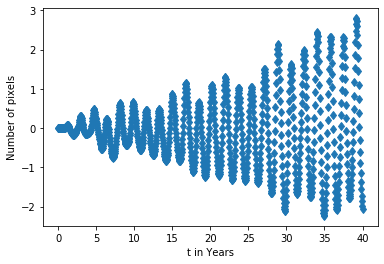

In [14]:
%%time
Furnisher('310+341+435')
MSaturn = (GMSaturnB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MUranus = (GMUranusB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MNeptune = (GMNeptuneB)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
gmSun = (GMSun+GMMercuryB+GMVenusB+GMEarthB)
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MIo2 = GMIo/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MEuropa2 = GMEuropa/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MGanymede2 = GMGanymede/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
MCallisto2 = GMCallisto/(GMSun+GMMercuryB+GMVenusB+GMEarthB)
xerr,yerr,times,distance,x,y = ErrorSource(['6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MSaturn,MUranus,MNeptune,MJupiter,MIo2,MEuropa2,MGanymede2,MCallisto2,0],[9,10,11,12,13,14,15],'Ananke','5',gmSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

# Try adding a J2

This is original test with all bodies in sim

<rebound.particle.Particle object at 0x7f91503e6a70, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 13.1 s, sys: 13 ms, total: 13.1 s
Wall time: 13.1 s


(-1, 1)

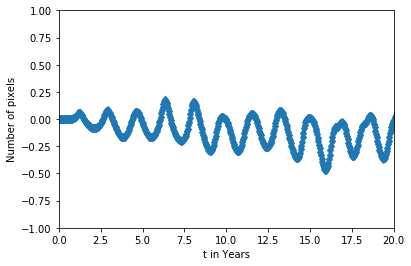

In [48]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Ananke','5',GMSun)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")
plt.xlim([0, 20])
plt.ylim([-1,1])

# All satellites + J2 of Jup

Improves things and errors now centered at zero

<rebound.particle.Particle object at 0x7f9170ba70e0, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 16.3 s, sys: 22.5 ms, total: 16.3 s
Wall time: 16.3 s


(-1, 1)

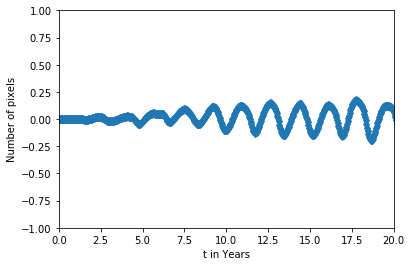

In [47]:
%%time
J2 = 0.014696 # Tremaine 09
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0],[9,10,11,12,13,14,15],'Ananke','5',GMSun, J2=J2)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")
plt.xlim([0, 20])
plt.ylim([-1,1])

# Replacing galilean satellites with a J2 is quite good for 20 years!

<rebound.particle.Particle object at 0x7f91709fdf80, m=0.0009517514775406745 x=-5.363981605794467 y=1.5680852517748214 z=0.8077495115561961 vx=-0.01804861030546609 vy=-0.006212704363883289 vz=-0.0026338012761289616>
1000 1000 1000
CPU times: user 669 ms, sys: 5.28 ms, total: 674 ms
Wall time: 673 ms


(-1, 1)

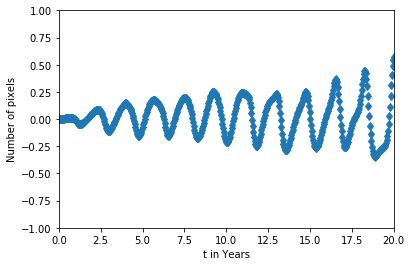

In [39]:
%%time
J2 = 0.045020 # Effective J2 including galilean satellites from Tremaine 09
Furnisher('310+341+435')
MJupiter = (GMJupiterB)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','5','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,0],[9],'Ananke','5',GMSun, J2=True)
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")
plt.xlim([0, 20])
plt.ylim([-1,1])